In [38]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor
import cv2
import matplotlib.pyplot as plt # Plotting
import numpy as np # Numeric data
import pandas as pd # Tabular data
from rasterio.features import shapes # Vectorising rasters to polygons
from shapely import Point, LineString # Geometry
from shapely.geometry import box, shape
import geopandas as gpd # Plotting polygons
from tqdm.auto import tqdm # Progress bars

In [39]:
# Load SegmentAnything
checkpoint = 'sam_vit_h_4b8939.pth'
sam = sam_model_registry['vit_h'](checkpoint=checkpoint)
device = 'cuda:0'
sam.to(device)

img = cv2.cvtColor(cv2.imread('test.png'), cv2.COLOR_BGR2RGB)

In [40]:
masks = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32, # The number of points to be sampled along one side of the image
    pred_iou_thresh=0.88, # A filtering threshold in [0,1], using the model's predicted mask quality.
    stability_score_thresh=0.95, # The amount to shift the cutoff when calculated the stability score.
    box_nms_thresh=0.7, # The box IoU cutoff used by non-maximal suppression to filter duplicate masks.
    crop_nms_thresh=0.7, # The box IoU cutoff used by non-maximal suppression to filter duplicate masks between different crops.
    crop_n_layers=0, #  If >0, mask prediction will be run again on crops of the image. Sets the number of layers to run, where each layer has 2**i_layer number of image crops.
    crop_n_points_downscale_factor=1, # The number of points-per-side sampled in layer n is scaled down by crop_n_points_downscale_factor**n.
    min_mask_region_area=0, # If >0, postprocessing will be applied to remove disconnected regions and holes in masks with area smaller than min_mask_region_area
).generate(img)
len(masks)

198

In [41]:
pd.DataFrame(masks).describe()

area  predicted_iou  stability_score
count     198.000000     198.000000       198.000000
mean     4637.994949       0.969648         0.982286
std     35336.168935       0.022110         0.009846
min        58.000000       0.884306         0.950000
25%       763.250000       0.960758         0.976069
50%       895.500000       0.974550         0.985009
75%      1187.250000       0.984681         0.990115
max    473919.000000       1.012357         0.998503

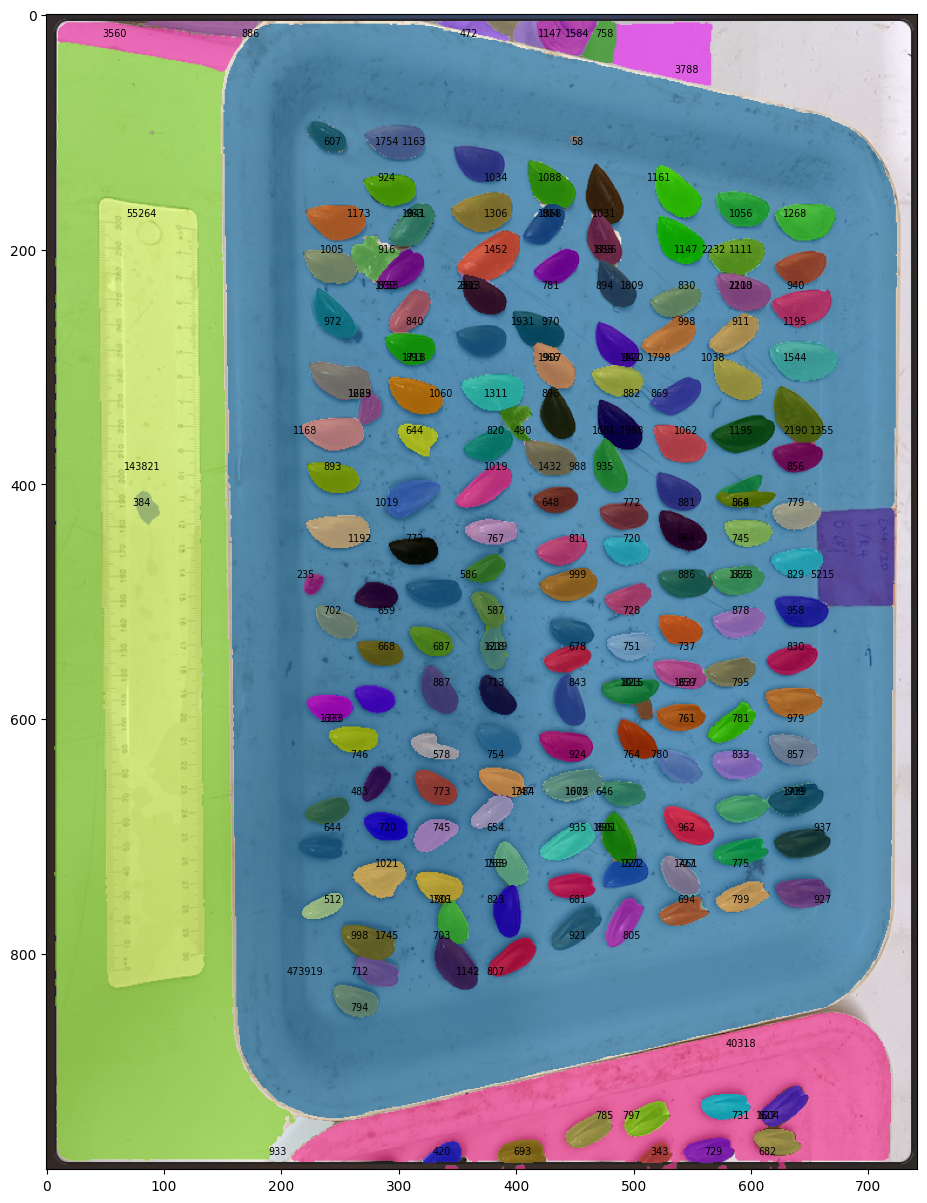

In [42]:
def show_anns(anns, opacity=.7):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [opacity]])
        img[m] = color_mask
        ax.annotate(ann["area"], ann["point_coords"][0], ha='center', va='center', fontsize="x-small")
    ax.imshow(img)

plt.figure(figsize=(15,15))
plt.imshow(img)
show_anns(masks)
plt.show() 

In [43]:
# Sort masks by area descending
masks = sorted(masks, key=(lambda x: x['area']), reverse=True)
print([s["area"] for s in masks[:10]])

[473919, 143821, 55264, 40318, 5215, 3788, 3560, 2313, 2232, 2200]


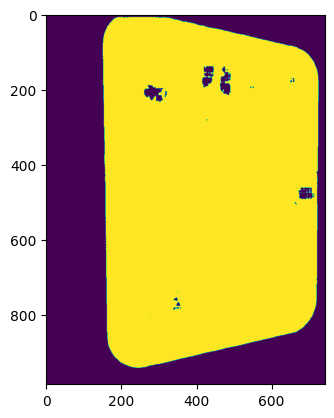

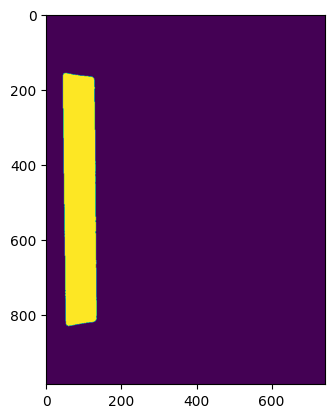

In [44]:
# Tray is largest, then the desk, then the ruler
tray = masks[0]
plt.imshow(tray["segmentation"])
plt.show()
ruler = masks[2]
plt.imshow(ruler["segmentation"])

In [45]:
ruler

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 55264,
 'bbox': [45, 157, 89, 672],
 'predicted_iou': 1.012357473373413,
 'point_coords': [[81.15625, 169.125]],
 'stability_score': 0.9879800081253052,
 'crop_box': [0, 0, 742, 984]}

In [46]:
ruler_height = ruler["bbox"][3]
# pixels to cm conversion. ruler is 32cm long
px_per_cm = ruler_height / 32
px_per_cm

21.0

[2313, 2232, 2200, 2190, 1998, 1931, 1907, 1868, 1841, 1820, 1809, 1798, 1796, 1778, 1754, 1753, 1745, 1739, 1718, 1672, 1663, 1637, 1601, 1589, 1572, 1544, 1501, 1461, 1452, 1432, 1384, 1355, 1333, 1311, 1306, 1268, 1229, 1219, 1195, 1195, 1192, 1173, 1168, 1163, 1161, 1147, 1142, 1113, 1111, 1088, 1081, 1062, 1060, 1056, 1038, 1034, 1031, 1021, 1019, 1019, 1015, 1005, 1005, 999, 998, 998, 988, 979, 972, 970, 966, 964, 963, 962, 958, 942, 940, 937, 935, 935, 927, 924, 924, 921, 916, 911, 909, 896, 895, 894, 893, 893, 887, 886, 886, 885, 883, 882, 881, 878, 869, 868, 859, 857, 856, 843, 840, 839, 833, 830, 830, 829, 823, 823, 820, 811, 807, 805, 804, 799, 795, 794, 786, 781, 781, 780, 779, 775, 773, 772, 772, 767, 764, 763, 761, 754, 751, 747, 746, 745, 745, 737, 728, 727, 721, 720, 720, 713, 712, 703, 702, 694, 693, 687, 681, 678, 668, 659, 654, 648, 646, 644, 644, 618, 607, 587, 586, 578, 564, 512]


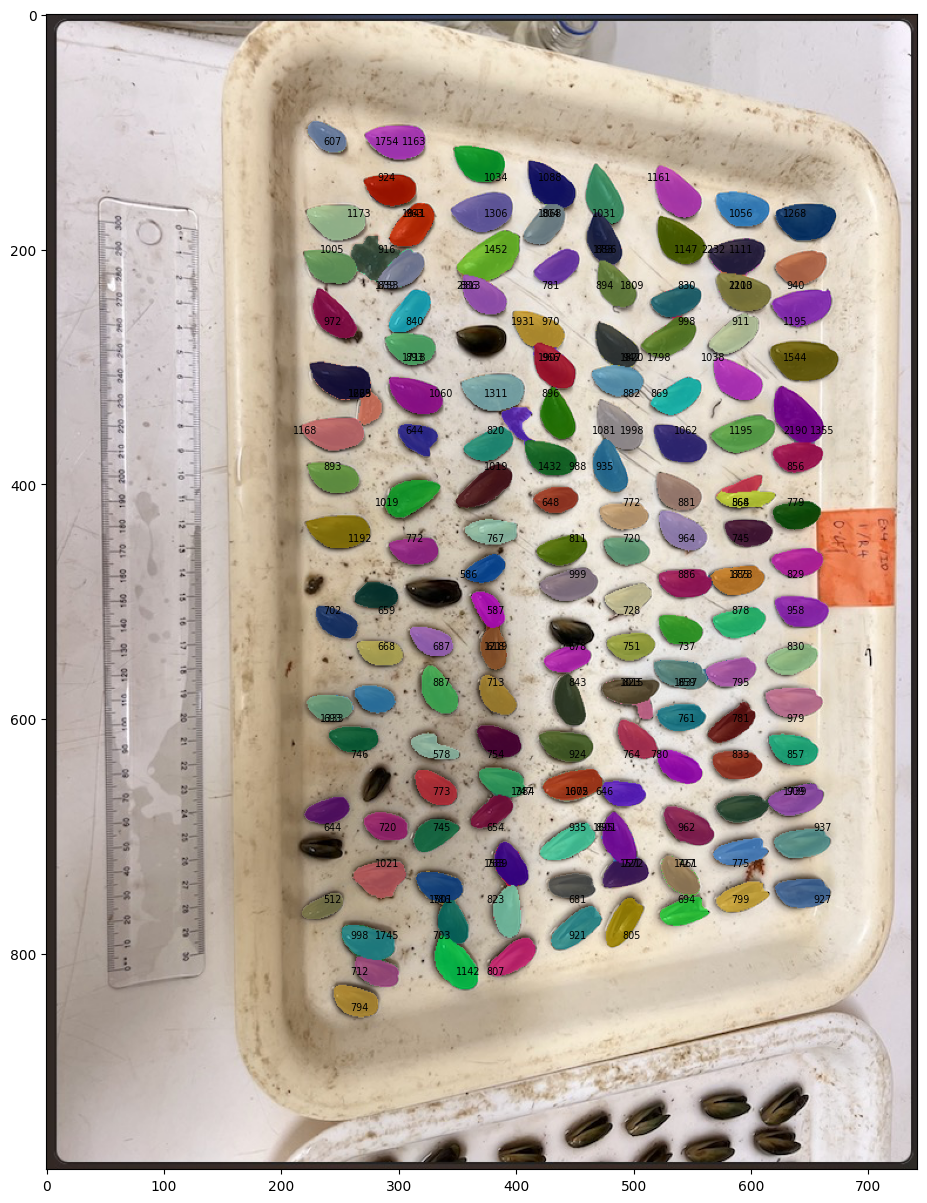

In [47]:
def within_tray(m):
  x,y,w,h = m["bbox"]
  tx,ty,tw,th = tray["bbox"]
  return (x > tx) and ((x+w) < (tx+tw-5)) and (y > ty) and ((y+h) < (ty+th))

things_in_tray = [m for m in masks if within_tray(m) and m["area"] > 500]
print([m["area"] for m in things_in_tray])
plt.figure(figsize=(15,15))
plt.imshow(img)
show_anns(things_in_tray)

In [48]:
len(things_in_tray)

170

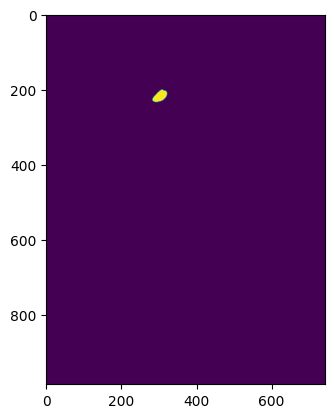

In [49]:
sample = np.random.choice(things_in_tray)
plt.imshow(sample["segmentation"])

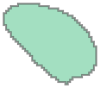

In [50]:
poly = shape(next(shapes(sample["segmentation"].astype(np.uint8)))[0])
poly

In [51]:
# Get diameter of polygon by brute force, checking each point pair
def get_diameter(poly):
    max_dist = 0
    coords = [Point(x,y) for x,y in poly.exterior.coords]
    result_coords = []
    for a in coords:
        for b in coords:
            dist = a.distance(b)
            if dist > max_dist:
                max_dist = dist
                result_coords = [a, b]

    line = LineString(result_coords)
    return line

line = get_diameter(poly)
line, line.length

(<LINESTRING (321 206, 283 230)>, 44.94441010848846)

Text(302.0, 218.0, '44.94px')

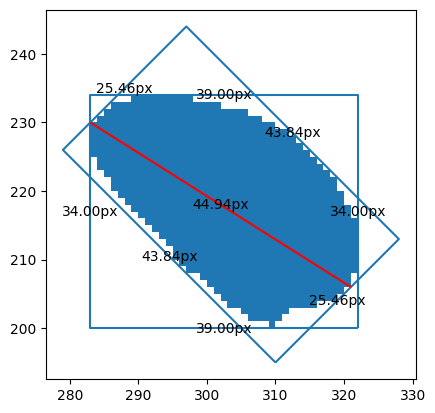

In [52]:
def get_dist(a, b):
    return Point(a).distance(Point(b))

def midpoint(a, b):
    return ((a[0]+b[0])/2, (a[1]+b[1])/2)

def annotate_dist(poly):
    coords = list(poly.exterior.coords)
    for i in range(len(coords)-1):
        a, b = coords[i], coords[i+1]
        dist = get_dist(a, b)
        plt.annotate(f"{dist:.2f}px", xy=midpoint(a, b), ha='center', va='center')

mrr = poly.minimum_rotated_rectangle
bbox = box(*poly.bounds)
line = get_diameter(poly)

ax = gpd.GeoSeries([poly, mrr.exterior, bbox.exterior]).plot()
gpd.GeoSeries(line).plot(color="red", ax=ax)
annotate_dist(bbox)
annotate_dist(mrr)
plt.annotate(f"{line.length:.2f}px", xy=midpoint(*list(line.coords)), ha='center', va='center')

In [53]:
def mask_to_line(mask):
    poly = shape(next(shapes(mask.astype(np.uint8), mask))[0])
    return get_diameter(poly)

In [54]:
ruler["diameter_line"] = mask_to_line(ruler["segmentation"])

In [55]:
for m in tqdm(things_in_tray):
    m["diameter_line"] = mask_to_line(m["segmentation"])

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

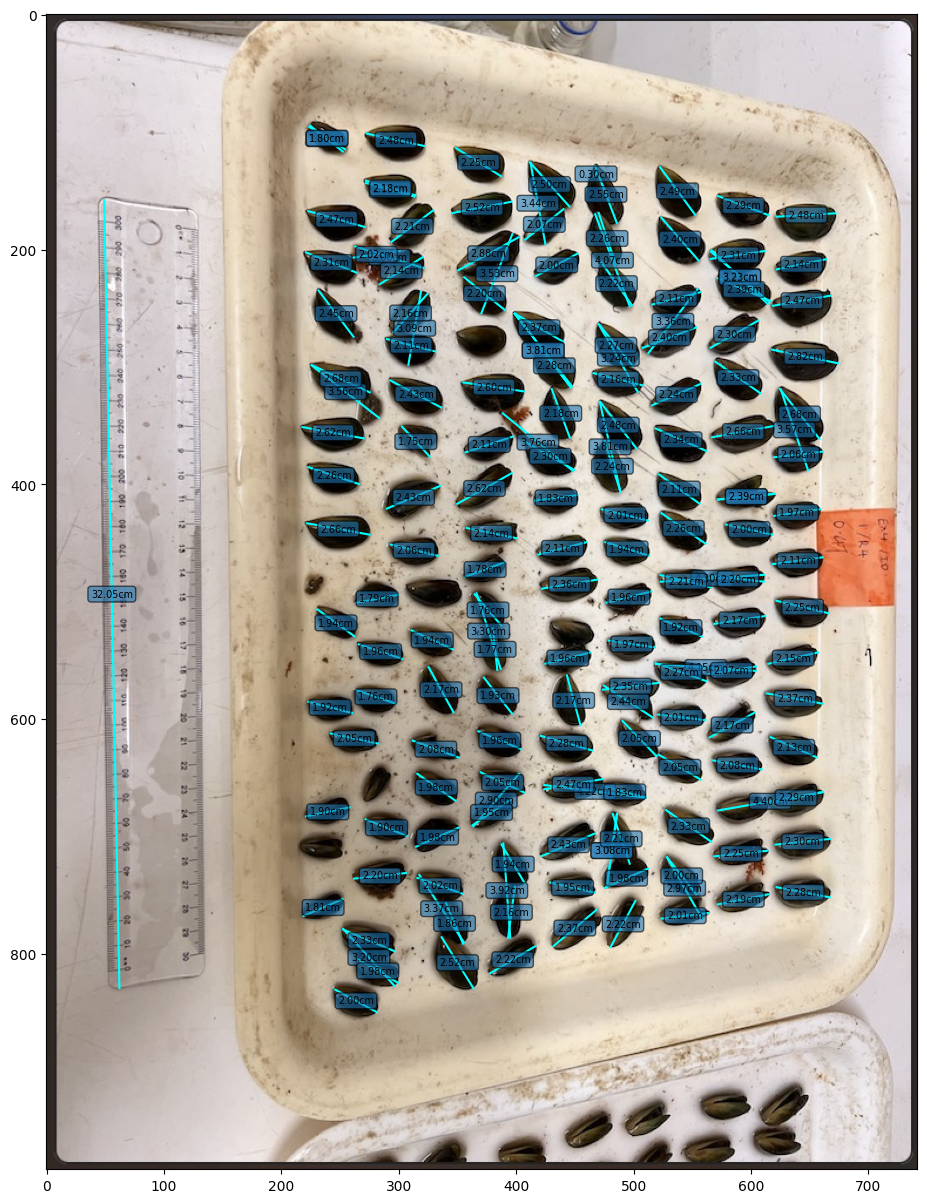

In [56]:
def annotate_length(mask):
    line = mask["diameter_line"]
    gpd.GeoSeries(line).plot(color="cyan", ax=plt.gca())
    x, y = midpoint(*list(line.coords))
    plt.text(s=f"{line.length/px_per_cm:.2f}cm", x=x, y=y, ha='center', va='center', bbox=dict(boxstyle="round", alpha=.6), fontsize="x-small")

plt.figure(figsize=(15,15))
plt.imshow(img)
annotate_length(ruler)
for m in tqdm(things_in_tray):
    annotate_length(m)

In [57]:
pd.Series([m["diameter_line"].length / px_per_cm for m in things_in_tray]).describe()

count    170.000000
mean       2.390517
std        0.587586
min        0.304911
25%        2.026580
50%        2.241384
75%        2.479393
max        4.399804
dtype: float64